In [1]:
!pip install catboost==0.26.1

In [2]:
import pandas as pd
import numpy as np
import datetime
#import dtale
#import dtale.app as dtale_app
import catboost as cb
import pickle

from sklearn import preprocessing
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
#from kmodes.kprototypes import KPrototypes

from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") 

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
!ls "/content/drive/My Drive/TFM_Velarte"

'car-causas-agrupadas(v2).ipynb'	   DF_SEGUN_VELARTE3csv.csv
'car-Cleaning_and_Clustering(v6).ipynb'    DF_SEGUN_VELARTE.csv
'car_Cleaning_and_Clustering(v7).ipynb'    ETL.ipynb
'car-Cleaning_and_Clustering(v7).ipynb'    Info
 Catboost.ipynb				  'Informe Producción y Mermas.xlsx'
 Cleaning_and_Clustering.ipynb		   Meetings
'Cleaning_and_Clustering(v3) (1).ipynb'    NEW.ipynb
'Cleaning_and_Clustering(v3).ipynb'	   OLD
'Cleaning_and_Clustering(v4) (1).ipynb'   'Presentación y Memoria'
'Cleaning_and_Clustering(v4).ipynb'	   Report_TFM.gdoc
'Copia de causas210918.ipynb'		   VELARTE_MERMA_CAUSAS.csv
'Copia de Cleaning_and_Clustering.ipynb'   VELARTE_MERMA_CAUSAS.gsheet
 Dashboard				   VELARTE_PROD_MERMA.csv
 DF_CLEAN_VELARTE.csv			   VELARTE_PROD_MERMA.gsheet
 DF_SEGUN_VELARTE2.csv


In [5]:
path= '/content/drive/My Drive/TFM_Velarte/DF_CLEAN_VELARTE.csv'
delimiter = ','
df = pd.read_csv(path, header='infer', delimiter=delimiter)

In [6]:
df.head(20)

,Articulo_Orden,Cantidad orden,Cantidad Merma,Cod_ Turno Trabajo,Location Code,Codigo_rechazo,Causa,Tipo,Weekday,Day,Month,Year
0,9030101,170.0,0.0,3,1,372,3,100,6,3,1,2016
1,9510205,80.0,0.0,3,2,372,3,100,0,4,1,2016
2,9510107,180.0,0.0,3,2,372,3,100,0,4,1,2016
3,9510101,288.0,0.0,3,1,372,3,100,0,4,1,2016
4,9500302,91.0,1.1,2,2,372,3,100,0,4,1,2016
5,9050324,80.0,0.0,3,2,372,3,100,0,4,1,2016
6,9050323,137.0,0.0,3,2,372,3,100,0,4,1,2016
7,9050320,720.0,0.0,2,2,372,3,100,0,4,1,2016
8,9050317,33.0,0.0,3,2,372,3,100,0,4,1,2016
9,9050315,64.0,0.0,1,2,372,3,100,0,4,1,2016


In [7]:
df['Articulo_Orden'].nunique()

374

In [8]:
df.shape

(11601, 12)

In [9]:
df.shape

(11601, 12)

In [10]:
df.isna().sum()

Articulo_Orden        0
Cantidad orden        0
Cantidad Merma        0
Cod_ Turno Trabajo    0
Location Code         0
Codigo_rechazo        0
Causa                 0
Tipo                  0
Weekday               0
Day                   0
Month                 0
Year                  0
dtype: int64

In [11]:
df.dtypes

Articulo_Orden          int64
Cantidad orden        float64
Cantidad Merma        float64
Cod_ Turno Trabajo      int64
Location Code           int64
Codigo_rechazo          int64
Causa                   int64
Tipo                    int64
Weekday                 int64
Day                     int64
Month                   int64
Year                    int64
dtype: object

In [12]:
#creating independent variables as X and target/dependent variable as y
X= df.loc[:, df.columns!= 'Cantidad Merma']
y= df['Cantidad Merma']

In [13]:
#Let’s split X and y using Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state= 42)
#get shape of train and test data
print("train data size:",X_train.shape)
print("test data size:",X_test.shape)

train data size: (9280, 11)
test data size: (2321, 11)


In [14]:
#List of categorical columns
categoricalcolumns = X.select_dtypes(include=["object"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
#Get location of categorical columns
cat_features = [X.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ",cat_features)

Names of categorical columns :  []
Location of categorical columns :  []


In [15]:
from catboost import Pool
train_dataset = cb.Pool(X_train, y_train, cat_features = ['Articulo_Orden','Cod_ Turno Trabajo', 'Location Code', 'Codigo_rechazo',	'Causa', 'Tipo', 'Weekday', 'Day', 'Month','Year'])
test_dataset = cb.Pool(X_test, y_test, cat_features = ['Articulo_Orden','Cod_ Turno Trabajo', 'Location Code', 'Codigo_rechazo',	'Causa', 'Tipo', 'Weekday', 'Day', 'Month','Year'])

In [16]:
my_model = cb.CatBoostRegressor(loss_function='RMSE')

In [17]:
grid = {'iterations': [300, 400, 500],
        'learning_rate': [0.04,0.05, 0.06],
        'depth': [6, 8, 7],
        'l2_leaf_reg': [4,2,3],
        'loss_function':['RMSE']}

In [18]:
grid_search = GridSearchCV(estimator=my_model, param_grid = grid, cv = 2, n_jobs=-1)
best_model = grid_search.fit(X_train, y_train)

0:	learn: 16.5964057	total: 49.3ms	remaining: 14.7s
1:	learn: 16.1860772	total: 51.7ms	remaining: 7.7s
2:	learn: 15.7991652	total: 54ms	remaining: 5.34s
3:	learn: 15.4406950	total: 56.3ms	remaining: 4.16s
4:	learn: 15.0870496	total: 58.7ms	remaining: 3.46s
5:	learn: 14.7454017	total: 61ms	remaining: 2.99s
6:	learn: 14.4234292	total: 63.3ms	remaining: 2.65s
7:	learn: 14.1110280	total: 65.6ms	remaining: 2.39s
8:	learn: 13.8374431	total: 67.9ms	remaining: 2.2s
9:	learn: 13.5747823	total: 70.5ms	remaining: 2.04s
10:	learn: 13.3119871	total: 72.7ms	remaining: 1.91s
11:	learn: 13.0708152	total: 77ms	remaining: 1.85s
12:	learn: 12.8447066	total: 80.4ms	remaining: 1.77s
13:	learn: 12.6230870	total: 85ms	remaining: 1.74s
14:	learn: 12.4204718	total: 87.3ms	remaining: 1.66s
15:	learn: 12.2233557	total: 89.6ms	remaining: 1.59s
16:	learn: 12.0456835	total: 91.9ms	remaining: 1.53s
17:	learn: 11.8721532	total: 94.3ms	remaining: 1.48s
18:	learn: 11.7114878	total: 96.7ms	remaining: 1.43s
19:	learn: 11

In [19]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", best_model.best_estimator_)
print("\n The best score across ALL searched params:\n", best_model.best_score_)
print("\n The best parameters across ALL searched params:\n", best_model.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.6722964521343727

 The best parameters across ALL searched params:
 {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 4, 'learning_rate': 0.04, 'loss_function': 'RMSE'}


In [20]:
from catboost import CatBoost
tuned_model = CatBoost(params=best_model.best_params_)

tuned_model = tuned_model.fit(X_train, y_train)

0:	learn: 16.5964057	total: 3.32ms	remaining: 992ms
1:	learn: 16.1860772	total: 6.85ms	remaining: 1.02s
2:	learn: 15.7991652	total: 13.8ms	remaining: 1.36s
3:	learn: 15.4406950	total: 17.1ms	remaining: 1.27s
4:	learn: 15.0870496	total: 19.6ms	remaining: 1.16s
5:	learn: 14.7454017	total: 22.3ms	remaining: 1.09s
6:	learn: 14.4234292	total: 24.6ms	remaining: 1.03s
7:	learn: 14.1110280	total: 26.9ms	remaining: 983ms
8:	learn: 13.8374431	total: 29.3ms	remaining: 948ms
9:	learn: 13.5747823	total: 31.8ms	remaining: 921ms
10:	learn: 13.3119871	total: 34ms	remaining: 894ms
11:	learn: 13.0708152	total: 36.3ms	remaining: 872ms
12:	learn: 12.8447066	total: 38.7ms	remaining: 853ms
13:	learn: 12.6230870	total: 41.1ms	remaining: 839ms
14:	learn: 12.4204718	total: 43.8ms	remaining: 832ms
15:	learn: 12.2233557	total: 48.2ms	remaining: 856ms
16:	learn: 12.0456835	total: 52.7ms	remaining: 877ms
17:	learn: 11.8721532	total: 55.3ms	remaining: 866ms
18:	learn: 11.7114878	total: 57.7ms	remaining: 853ms
19:	l

In [21]:
# It is important to use binary access
with open('catboost.pickle', 'wb') as f:
    pickle.dump(tuned_model, f)

In [22]:
tuned_model = pickle.load(open('catboost.pickle', 'rb'))

In [23]:
y_pred = tuned_model.predict(X_test)

In [24]:
y_pred

array([ 0.23838182, 44.7103225 ,  0.48888537, ...,  0.6808016 ,
        0.33048653,  0.21369174])

In [25]:
y_pred = tuned_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 8.55
R2: 0.69


In [26]:
test_preds = tuned_model.predict(X_test)
train_preds = tuned_model.predict(X_train)

test_preds[:5], train_preds[:5]

(array([ 0.23838182, 44.7103225 ,  0.48888537,  0.90053368,  0.10134868]),
 array([3.96273924e-05, 3.32359209e-01, 5.36828117e-01, 3.83882965e-01,
        5.79792161e-01]))

Text(0.5, 0, 'CatBoost Feature Importance')

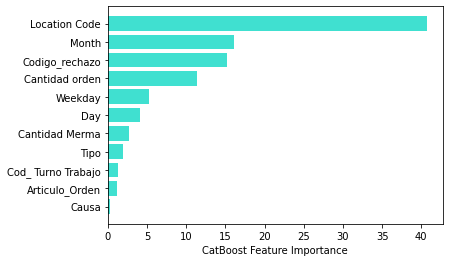

In [27]:
sorted_feature_importance = tuned_model.feature_importances_.argsort()
plt.barh(df.columns[sorted_feature_importance], 
        tuned_model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")


In [28]:
X_test.head()

,Articulo_Orden,Cantidad orden,Cod_ Turno Trabajo,Location Code,Codigo_rechazo,Causa,Tipo,Weekday,Day,Month,Year
5384,9010496,120.0,3,1,372,3,2,6,4,6,2017
9498,9010527,420.0,1,1,71,1,1,2,20,2,2019
2952,9500134,72.0,1,1,372,3,100,2,29,6,2016
6654,9050270,324.0,3,1,372,3,2,4,2,3,2018
10986,9500351,31.0,1,1,372,3,100,4,17,5,2019


In [29]:
y_test.head()

5384      0.0
9498     90.0
2952      0.0
6654      0.0
10986     0.0
Name: Cantidad Merma, dtype: float64

In [30]:
y_pred[:5]

array([ 0.23838182, 44.7103225 ,  0.48888537,  0.90053368,  0.10134868])

In [31]:
#We try to predict with a random value

In [32]:
X_test=[9050277,3,2,2,372,3,1,5,9,2019,1]

In [33]:
y_pred = tuned_model.predict(X_test)

In [34]:
y_pred

0.33421187187576695